In [1]:
#!/usr/bin/python
import sys
import os
import os.path
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
from astropy.table import Table, Column 
import pyfits
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib import gridspec

Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3140f49110>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f314140a350>)

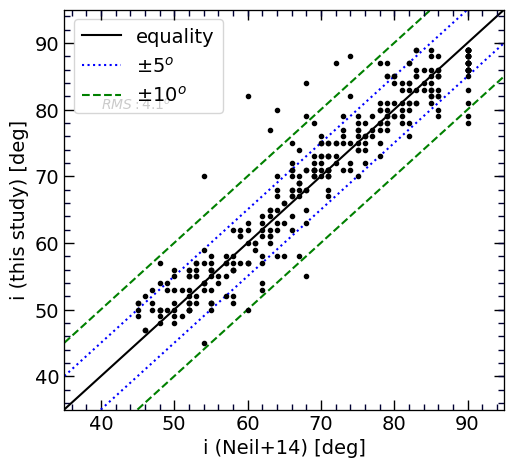

In [2]:
def add_axis(ax, xlim, ylim):
    
    x1, x2 = xlim[0], xlim[1]
    y1, y2 = ylim[0], ylim[1]
    ax.set_xlim(x1, x2)
    ax.set_ylim(y1, y2)

    ax.minorticks_on()
    ax.tick_params(which='major', length=7, width=1.0, direction='in')
    ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(MultipleLocator(2))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(2))
    
    # additional Y-axis (on the right)
    y_ax = ax.twinx()
    y_ax.set_ylim(y1, y2)
    y_ax.set_yticklabels([])
    y_ax.minorticks_on()
    y_ax.yaxis.set_major_locator(MultipleLocator(10))
    y_ax.yaxis.set_minor_locator(MultipleLocator(2))
    y_ax.tick_params(which='major', length=7, width=1.0, direction='in')
    y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    # additional X-axis (on the top)
    x_ax = ax.twiny()
    x_ax.set_xlim(x1, x2)
    x_ax.set_xticklabels([])
    x_ax.minorticks_on()
    x_ax.xaxis.set_major_locator(MultipleLocator(10))
    x_ax.xaxis.set_minor_locator(MultipleLocator(2))
    x_ax.tick_params(which='major', length=7, width=1.0, direction='in')
    x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')

    for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(14) 
            
    return x_ax, y_ax
################################################################# 
######################################
class cd:
    """Context manager for changing the current working directory"""
    def __init__(self, newPath):
        self.newPath = os.path.expanduser(newPath)

    def __enter__(self):
        self.savedPath = os.getcwd()
        os.chdir(self.newPath)

    def __exit__(self, etype, value, traceback):
        os.chdir(self.savedPath)
 
######################################

def get_ellipse(filename):
          
          ra_cen = -1
          dec_cen = -1
          semimajor = -1
          semiminor = -1
          PA = -1
          with open(filename) as f:
            counter = 1
            for line in f:
              if counter == 14:
                line_split = line.split(" ")
                not_void = 0 
                set_param = False
                for thing in line_split:
                  if thing != '': 
                      not_void+=1
                      set_param = True
                  if not_void==1 and set_param: 
                      set_param = False
                      ra_cen=np.float(thing) 
                  if not_void==2 and set_param: 
                      dec_cen=np.float(thing) 
                      set_param = False
                  if not_void==3 and set_param: 
                      semimajor=np.float(thing) 
                      set_param = False
                  if not_void==4 and set_param: 
                      semiminor=np.float(thing)
                      set_param = False
                  if not_void==5 and set_param: 
                      PA=np.float(thing) 
                      break
                return ra_cen, dec_cen, semimajor, semiminor, PA
              counter+=1   
#################################
def ra_db(ra):   # returns a string
  
     ra_id = str(int(np.floor(ra)))
     if ra < 10:
       ra_id = '00'+ra_id+'D'
     elif ra < 100:
       ra_id = '0'+ra_id+'D'
     else:
       ra_id = ra_id+'D'
  
     return ra_id
#################################
######################################
def xcmd(cmd,verbose):

  if verbose: print '\n'+cmd

  tmp=os.popen(cmd)
  output=''
  for x in tmp: output+=x
  if 'abort' in output:
    failure=True
  else:
    failure=tmp.close()
  if False:
    print 'execution of %s failed' % cmd
    print 'error is as follows',output
    sys.exit()
  else:
    return output

######################################


inFile  = '../EDD_distance_cf4_v27.csv'

# inFile = 'corrected_mags_linewidth_all.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=None, names=True, dtype=None)
pgc     = table['pgc']
inc = table['inc']  
##################################################
# inFile = '/home/ehsan/PanStarrs/INClinationCode/pgc_ehsan_calib.lst.output'
# table = np.genfromtxt(inFile , delimiter=',', filling_values=None, names=True, dtype=None)
# pgc    = table['pgc']
# inc    = table['inc']
# flag_incout   = table['flag']
##################################################
inFile = '../Wise_calib_visier.csv'
table = np.genfromtxt(inFile , delimiter='|', filling_values=None, names=True, dtype=None)
pgc_wise_vizier    = table['PGC']
inc_wise_vizier    = table['i']
b_a_wise_vizier    = table['b_a']
##################################################

my_inc     = []
th_inc     = []

for i in range(len(pgc_wise_vizier)):
    if pgc_wise_vizier[i] in pgc:
        i_lst = np.where(pgc == pgc_wise_vizier[i])
        if True: # inc_flg[i_lst][0]<=0:# and inc_n[i_lst][0]>1:
#          if inc_wise_vizier[i]<90:
            my_inc.append(inc[i_lst][0]-1)
            th_inc.append(inc_wise_vizier[i])
#             print pgc_wise_vizier[i], pgc[i_lst][0]
           
        
fig = py.figure(figsize=(5.5, 5), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)    


p1, = ax.plot([0,100], [0,100], color='black', linestyle='-', label="equality")
p2, = ax.plot([0,100], [5,105], color='b', linestyle=':', label=r'$\pm5^o$')
ax.plot([0,100], [-5,95], color='b', linestyle=':')
p3, = ax.plot([0,100], [10,110], color='g', linestyle='--', label=r'$\pm10^o$')
ax.plot([0,100], [-10,90], color='g', linestyle='--')
ax.plot(th_inc, my_inc, 'k.', picker=5)



th_inc0 = np.asarray(th_inc)
my_inc0 = np.asarray(my_inc)

index, = np.where((th_inc0<88) & (th_inc0>50))

th_inc = th_inc0[index]
my_inc = my_inc0[index]

delta = th_inc-my_inc
delta = delta[np.where(delta<8)]
std = np.std(delta)
rms = np.sqrt(np.mean(delta**2))

ax.set_xlim([20,100])
ax.set_ylim([20,100])
ax.text(40,80, r'$RMS: $'+"%.1f" % (rms)+r'$^o$')
#ax.text(30,90, r'$\sigma: $'+"%.1f" % (std)+r'$^o$')
ax.set_xlabel('i (Neil+14) [deg]', fontsize=14)
ax.set_ylabel('i (this study) [deg]', fontsize=14)
ax.tick_params(which='major', length=5, width=2.0, direction='in')
ax.tick_params(which='minor', length=2, color='#000033', width=1.0, direction='in')
ax.minorticks_on()

# Legend
lns = [p1, p2, p3]
ax.legend(handles=lns, loc=2, fontsize=14)
add_axis(ax, [35,95], [35,95])

Text(45,-8,'$RMS: $4.1$^o$')

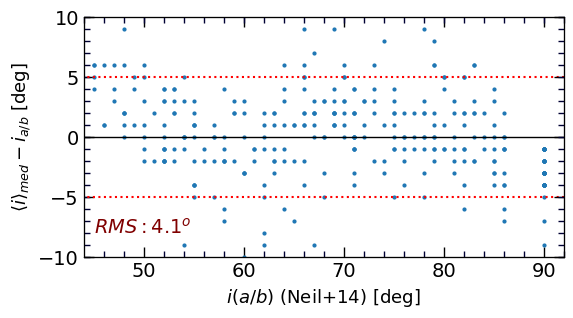

In [3]:
fig = py.figure(figsize=(6, 3), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)   
ax.plot(th_inc0, my_inc0-th_inc0, 'o', ms=2)

x_ax, y_ax = add_axis(ax, [44,92], [-10,10])

ax.plot([-10,100], [0,0], 'k-', lw=1)
ax.plot([-10,100], [5,5], 'r:')
ax.plot([-10,100], [-5,-5], 'r:')

ax.set_xlabel(r'$i({a/b})$'+' (Neil+14) [deg]', fontsize=13)
ax.set_ylabel(r'$\langle i \rangle_{med} - i_{a/b}$'+' [deg]' , fontsize=13)

y_ax.yaxis.set_major_locator(MultipleLocator(5))
y_ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.text(45,-8, r'$RMS: $'+"%.1f" % (rms)+r'$^o$', fontsize=14, color='maroon')

Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


10736


Text(48,2500,'N = 10736 galaxies')

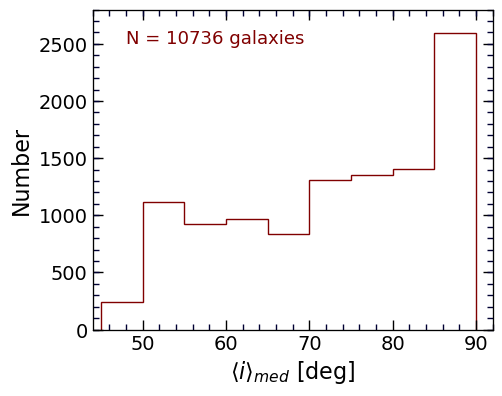

In [4]:
inFile = 'corrected_mags_linewidth_all.csv'
table   = np.genfromtxt(inFile , delimiter='|', filling_values=None, names=True, dtype=None)
pgc0 = table['pgc']
inc0 = table['inc']  

fig = py.figure(figsize=(5, 4), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)   

bins = np.arange(45, 95, 5)
n, bins, patches = ax.hist(inc0 , bins, histtype='step',color=['maroon'], label=['label'], 
                           fill=False, stacked=True)

print len(inc0)
ax.set_xlabel(r'$\langle i \rangle_{med} \/\/$[deg]', fontsize=16)
ax.set_ylabel('Number', fontsize=16)

x_ax, y_ax = add_axis(ax, [44,92], [0,2800])

y_ax.yaxis.set_major_locator(MultipleLocator(500))
y_ax.yaxis.set_minor_locator(MultipleLocator(100))

ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))

ax.text(48,2500, 'N = '+'%d'%len(inc0)+' galaxies', fontsize=13, color='maroon')

In [5]:
inFile = '../EDD_distance_cf4_v27.csv'
table = np.genfromtxt(inFile , delimiter='|', filling_values=None, names=True, dtype=None)
pgc_incout    = table['pgc']
inc_incout    = table['inc']
inc_n   = table['inc_n']



Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [6]:
pgc0.shape

(10736,)

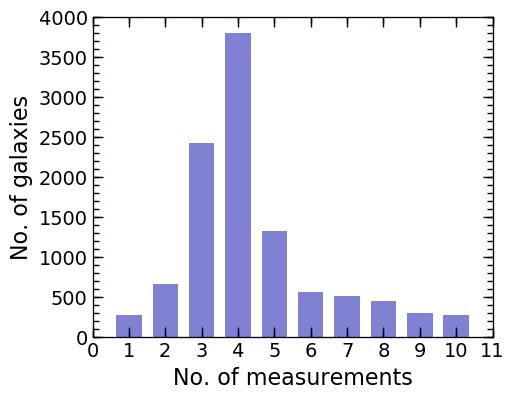

In [55]:
n_lst = []
for id in pgc0:
    if id in pgc_incout:
        i, = np.where(pgc_incout==id)
        n_lst.append(inc_n[i][0])

fig = py.figure(figsize=(5, 4), dpi=100)
fig.subplots_adjust(hspace=0.15, top=0.95, bottom=0.15, left=0.15, right=0.95)
ax = fig.add_subplot(111)  

bins = np.arange(1, 12, 1)
# n, bins, patches = ax.hist(n_lst , bins, histtype='step',color=['maroon'], label=['label'], 
#                            fill=False, stacked=True)
        
ax.bar(bins[:-1], n, width = 0.7, color='#0504aa',alpha=0.5)


ax.set_xlabel('No. of measurements', fontsize=16)
ax.set_ylabel('No. of galaxies', fontsize=16)

x_ax, y_ax = add_axis(ax, [0,11], [0,4000])

y_ax.yaxis.set_major_locator(MultipleLocator(500))
y_ax.yaxis.set_minor_locator(MultipleLocator(100))

ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_minor_locator(MultipleLocator(100))

x_ax.xaxis.set_major_locator(MultipleLocator(1))
x_ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(1))


In [43]:
len(np.where(np.asarray(n_lst)<=2)[0])

925